# Data visualization of COVID19 epidemic

## Load libraries

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
import scipy
# np.__version__
%matplotlib inline
scipy.__version__
# import datetime
# now = datetime.datetime.now()

'1.4.1'

## Load data

In [74]:
# Johns Hopkins data
url='https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv
# https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv
filename_covid_timeseries='time_series_covid19_confirmed_global.csv'
urllib.request.urlretrieve(url,filename_covid_timeseries)
covid2020_data=pd.read_csv(filename_covid_timeseries)

# https://covid.ourworldindata.org/data/ecdc/full_data.csv
# https://github.com/owid/covid-19-data/tree/master/public/data


### world pop data

In [75]:
worldpop_filename='worldpop.csv'
urlworldpop='https://github.com/datasets/population/raw/master/data/population.csv'
# urllib.request.urlretrieve(urlworldpop,worldpop_filename)
worldpop=pd.read_csv(worldpop_filename)
# in millions
worldpop["Value"]=worldpop["Value"]/1e6
# last year of data
worldpop2018=worldpop[worldpop['Year']==2018]
# worldpop2018[worldpop2018['Country Name'].str.contains('|'.join(sel_countrs))]

In [76]:
### alternative data source
# https://github.com/owid/covid-19-data/tree/master/public/data

# FILTER
western_cntrs=['Austria','Switzerland','Belgium','Netherlands','Italy','Spain','France','Germany',\
               'United Kingdom','Ireland',\
               'Canada','US',\
               'Norway','Denmark','Finland','Sweden',\
               'New Zealand','Australia'] 
eastern_eur_cntrs=['Czechia','Hungary','Poland','Russia','Ukraine',\
                   'Romania','Belarus','Bulgaria','Croatia','Slovakia']
east_asian_cntrs=['Korea','Japan','China','Singapore','Taiwan','Thailand','Vietnam',\
             'Indonesia','Thailand','Malaysia','Philippines']
south_west_asia=['Bangladesh','India','Pakistan','Afghanistan','Turkey',\
                 'Iran','Iraq','Saudi Arabia','United Arab Emirates','Qatar']
latin_am_cntrs=['Argentina','Brazil','Colombia','Mexico','Peru','Venezuela','Chile','Ecuador','Guatemala','Cuba']
afr_cntrs=['Nigeria','Ethiopia','Egypt','South Africa','Algeria','Kenya','Morocco','Congo','Ghana','Cameroon']
# 
countries=western_cntrs+eastern_eur_cntrs+east_asian_cntrs+south_west_asia+latin_am_cntrs+afr_cntrs
covid2020_data_sel=covid2020_data[covid2020_data['Country/Region'].str.contains('|'.join(countries))]
covid2020_data_sel=covid2020_data_sel.groupby(['Country/Region']).sum()
covid2020_data_sel=covid2020_data_sel.iloc[:,~covid2020_data_sel.columns.str.contains('|'.join(['Lat','Long']))]
# remove BRazzaville Congo: 
covid2020_data_sel=covid2020_data_sel[~covid2020_data_sel.index.str.contains('Brazzaville')]
# continent tag
covid2020_data_sel["Continent"]=''
all_cntr_categs=[western_cntrs,eastern_eur_cntrs,east_asian_cntrs,south_west_asia,latin_am_cntrs,afr_cntrs]
all_cntr_categs_strs=['Western','EastEur','EastAsia','SWAsia','LatAm','Africa']
for i in range(len(all_cntr_categs_strs)):
    covid2020_data_sel.loc[covid2020_data_sel.index.str.contains('|'.join(all_cntr_categs[i])),"Continent"]=\
    all_cntr_categs_strs[i]
#####
col_inds=(~covid2020_data_sel.columns.str.contains('Continent'))
# add a row with sum of 5 big European countries
IT_ES_FR_DE_UK=['Italy','Spain','France','Germany','United Kingdom']
# sum of EU big 5
covid2020_data_sel.loc['IT_ES_FR_DE_UK']=\
np.sum(covid2020_data_sel.iloc[covid2020_data_sel.index.str.contains('|'.join(IT_ES_FR_DE_UK)),:])
#
covid2020_data_sel.iloc[covid2020_data_sel.index.str.contains('IT_ES_FR_DE_UK'),-1]='Western'
# renamings
covid2020_data_sel.rename(index={'Taiwan*': 'Taiwan'},inplace=True)
covid2020_data_sel.rename(index={'Slovakia': 'Slovak Republic'},inplace=True)
covid2020_data_sel.rename(index={'US':'United States'},inplace=True);
western_cntrs[western_cntrs.index('US')]='United States'
#
covid2020_data_sel.rename(index={'Korea, South': 'South Korea'},inplace=True);
east_asian_cntrs[east_asian_cntrs.index('Korea')]='South Korea'
#
covid2020_data_sel.rename(index={'Congo (Kinshasa)': 'Congo, Dem. Rep.'},inplace=True);
afr_cntrs[afr_cntrs.index('Congo')]='Congo, Dem. Rep.'
# indices ordered
inds_ordered=[]
for i in range(len(all_cntr_categs)):
    vals=np.nonzero(np.array(covid2020_data_sel.index.str.contains('|'.join(all_cntr_categs[i]))))[0]
    inds_ordered=np.append(inds_ordered,vals).astype('int')
west_row_inds=(covid2020_data_sel['Continent']=='Western')
east_asian_row_inds=(covid2020_data_sel['Continent']=='EastAsia')

In [915]:
# covid2020_data_sel.iloc[:16:,-5:]
# covid2020_data[covid2020_data['Country/Region'].str.contains('Slovak')] #  eastern_eur_cntrs
#covid2020_data[covid2020_data['Country/Region'].str.contains('|'.join(south_west_asia))]
#worldpop2018[worldpop2018['Country Name'].str.contains('|'.join(south_west_asia))]
# covid2020_data_sel.iloc[:17,-10:]

## Functions

### Create fcn for plotting trajs starting from same value

In [5]:
### fcn to plot aligned
def fcn_plot_aligned(ax_plot,cumul_diff_flag,dataframe_plot,popul_data,sample_cntrs,\
                     ref_value,dashed_cntrs,dotted_cntrs,linewidth_incr_cntrs,\
                     xlimvals,ylimvals,xtick_stepval,fontsizeval,linewidth_vals,\
                     log_flag,text_flag,posit_modif_cntrs,posit_modif_vals):
    ax=ax_plot
    for compare_country_inds in range(len(sample_cntrs)):
        compare_country=sample_cntrs[compare_country_inds]
        # dataframe_plot.index[dataframe_plot.index.str.contains(sample_cntrs[compare_country_inds])][0]
        compare_country_truthval=dataframe_plot.index.str.contains(compare_country)
        if len(popul_data)==0:
            popval=1
        else:
            # bc of naming conventions some cntrs have diff. names in popul data...
            if compare_country=='South Korea':
                popval=popul_data.loc[popul_data['Country Name']=='Korea, Rep.','Value'].values
            elif compare_country=='Czechia':
                popval=popul_data.loc[popul_data['Country Name']=='Czech Republic','Value'].values
            elif compare_country in ['Russia','Iran','Egypt','Venezuela'] :
                popval=popul_data.loc[popul_data['Country Name'].str.contains(compare_country),'Value'].values
            elif compare_country=='IT_ES_FR_DE_UK':
                eur_big5=['Italy','Spain','Germany','France','United Kingdom']
                truthval_eur_big5=popul_data['Country Name'].str.contains('|'.join(eur_big5))
                pop_val=np.sum(popul_data.loc[truthval_eur_big5,'Value'])
            elif compare_country=='Taiwan':
                popval=23.726
            else:
                popval=popul_data.loc[popul_data['Country Name']==compare_country,'Value'].values
        devs=np.array(np.abs(dataframe_plot.iloc[compare_country_truthval,:-1].values/popval-ref_value))[0]
        min_dev_ind=np.max(np.where(devs==np.min(devs))[0]); match_date=dataframe_plot.columns[min_dev_ind]
        cases_rangevals=np.arange(min_dev_ind,dataframe_plot.columns.size-1)
        cases_other=dataframe_plot.loc[compare_country][cases_rangevals].values
        cases_other=cases_other/popval; 
        linestyle_val='-'; linewidth_val=linewidth_vals[0]
        if compare_country in dashed_cntrs:
            linestyle_val='--'
        elif compare_country in dotted_cntrs:
            linestyle_val=':'
        elif compare_country in linewidth_incr_cntrs:
            linewidth_val=linewidth_vals[1]
        if cumul_diff_flag in 'cumul':
            ax_plot.plot(np.arange(0,cases_other.size),cases_other,label=compare_country+" since "+match_date,\
                     linestyle=linestyle_val,linewidth=linewidth_val)
            # rounding
            if cases_other[-1]>5e4:
                num_text_val=str(np.round(cases_other[-1]/1e3,0).astype(int))+"e3"
            elif cases_other[-1]>1e4:
                num_text_val=str(np.round(cases_other[-1]/1e3,1))+"e3"
            elif cases_other[-1]>1e3:
                num_text_val=str(np.round(cases_other[-1]/1e3,2))+"e3"
            else:
                num_text_val=str(cases_other[-1].astype(int))
            # text inserts
            if text_flag:
                xval_text=np.min([xlimvals[1]-3,cases_other.size])-0.5; yval_text=cases_other[-1]
                num_text=compare_country+" ("+num_text_val+")"
                if len(posit_modif_cntrs)>0:
                    for j in range(len(posit_modif_cntrs)):
                        if compare_country in posit_modif_cntrs[j]:
                            xval_text=xval_text+posit_modif_vals[j][0]; yval_text=yval_text*posit_modif_vals[j][1]
                ax_plot.text(xval_text,yval_text,num_text)
        else:
            n_aver=3
            ax_plot.plot(np.arange(1,cases_other.size-n_aver+1),running_mean(np.diff(cases_other),n_aver),\
                 label=compare_country+" since "+match_date,\
                 linestyle=linestyle_val,linewidth=linewidth_val)
    #### end of loop
    if log_flag:
        ax_plot.set_yscale('log');
    ax_plot.set_ylim(ylimvals); plt.xticks(np.arange(0,xlimvals[1],step=xtick_stepval)); plt.xticks(rotation=90); 
    plt.xlim(xlimvals); plt.grid(which='major',linestyle='--'); 
    plt.rc('font',size=fontsizeval)

####################

### Fcn to plot growth rate

In [6]:
# function to calc sliding average
def running_mean(x,N):
    cumsum = np.nancumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N])/float(N)

def fcn_plot_growth_rate(dataframe_plot,popul_data,sel_countrs,cutoff_cases,growth_rate_flag,n_aver,\
                        dotted_cntrs,thickline_cntrs,dashed_cntrs,markervals,linewidth_vals,\
                        loglog_flag,xlim_vals,ylim_vals,str_dtype):
    for i in range(len(sel_countrs)):
        cases_cntr=dataframe_plot.loc[sel_countrs[i]][:-1].copy()
        cases_cntr_sel=cases_cntr[cases_cntr>cutoff_cases]
        # popul
        if sel_countrs[i]=='South Korea':
            popval=popul_data.loc[popul_data['Country Name']=='Korea, Rep.','Value'].values
        elif sel_countrs[i]=='IT_ES_FR_DE_UK':
            eur_big5=['Italy','Spain','Germany','France','United Kingdom']
            truthval_eur_big5=worldpop2018['Country Name'].str.contains('|'.join(eur_big5))
            popval=np.sum(worldpop2018.loc[truthval_eur_big5,'Value'])
        elif sel_countrs[i]=='Czechia':
            popval=popul_data.loc[popul_data['Country Name']=='Czech Republic','Value'].values
        elif sel_countrs[i]=='Taiwan':
            popval=23.726
        elif sel_countrs[i] in ['Russia','Iran','Egypt','Venezuela'] :
            popval=popul_data.loc[popul_data['Country Name'].str.contains(sel_countrs[i]),'Value'].values
        else:
            popval=popul_data.loc[popul_data['Country Name']==sel_countrs[i],'Value'].values
        ###
        # growth rate on cumulative number of cases
        if 'cumul' in growth_rate_flag:
            gr_rate=np.diff(cases_cntr_sel)/cases_cntr_sel[0:cases_cntr_sel.size-1]; # n_aver=3
        else:
            gr_rate=np.diff(cases_cntr_sel)/popval
        ####
        if sel_countrs[i] in dotted_cntrs:
            linewidth_val=linewidth_vals[0]; markerval=markervals[1]; markersize_val=4; linestyle_val=':'
        elif sel_countrs[i] in thickline_cntrs:
            linewidth_val=linewidth_vals[1]; linestyle_val='-'; markerval=markervals[0]; markersize_val=4
        elif sel_countrs[i] in dashed_cntrs:
            linewidth_val=linewidth_vals[0]; linestyle_val='--'; markerval=markervals[0]; markersize_val=4
        else:
            linewidth_val=linewidth_vals[0]; linestyle_val='-'; markersize_val=4; markerval=markervals[0]
        gr_rate[gr_rate==0]=np.nan
        # plot sliding average
        ax1.plot(cases_cntr_sel[n_aver:]/popval,running_mean(np.array(gr_rate),n_aver),\
                 label=sel_countrs[i], linestyle=linestyle_val,linewidth=linewidth_val,\
                 marker=markerval,markersize=markersize_val)
        plt.xlabel("cumulative number confirmed "+str_dtype+"/million"); 
        if loglog_flag[0]: ax1.set_xscale('log'); 
        if loglog_flag[1]: ax1.set_yscale('log'); 
        if 'cumul' in growth_rate_flag:
            plt.ylabel("% growth on cumulative "+str_dtype+"number"); 
            if len(ylim_vals): plt.ylim(ylim_vals)
            # plt.title("% growth on cumulative "+str_dtype+"number (moving average of 3 days)")
        else:
            # plt.title("new "+str_dtype+"/million population (moving average of 3 days)"); 
            plt.ylabel("new "+str_dtype+"/million population"); 
            if len(ylim_vals): plt.ylim(ylim_vals) 
            if len(xlim_vals): plt.xlim(xlim_vals)

## Plot # of total cases, aligned to start from ~same value

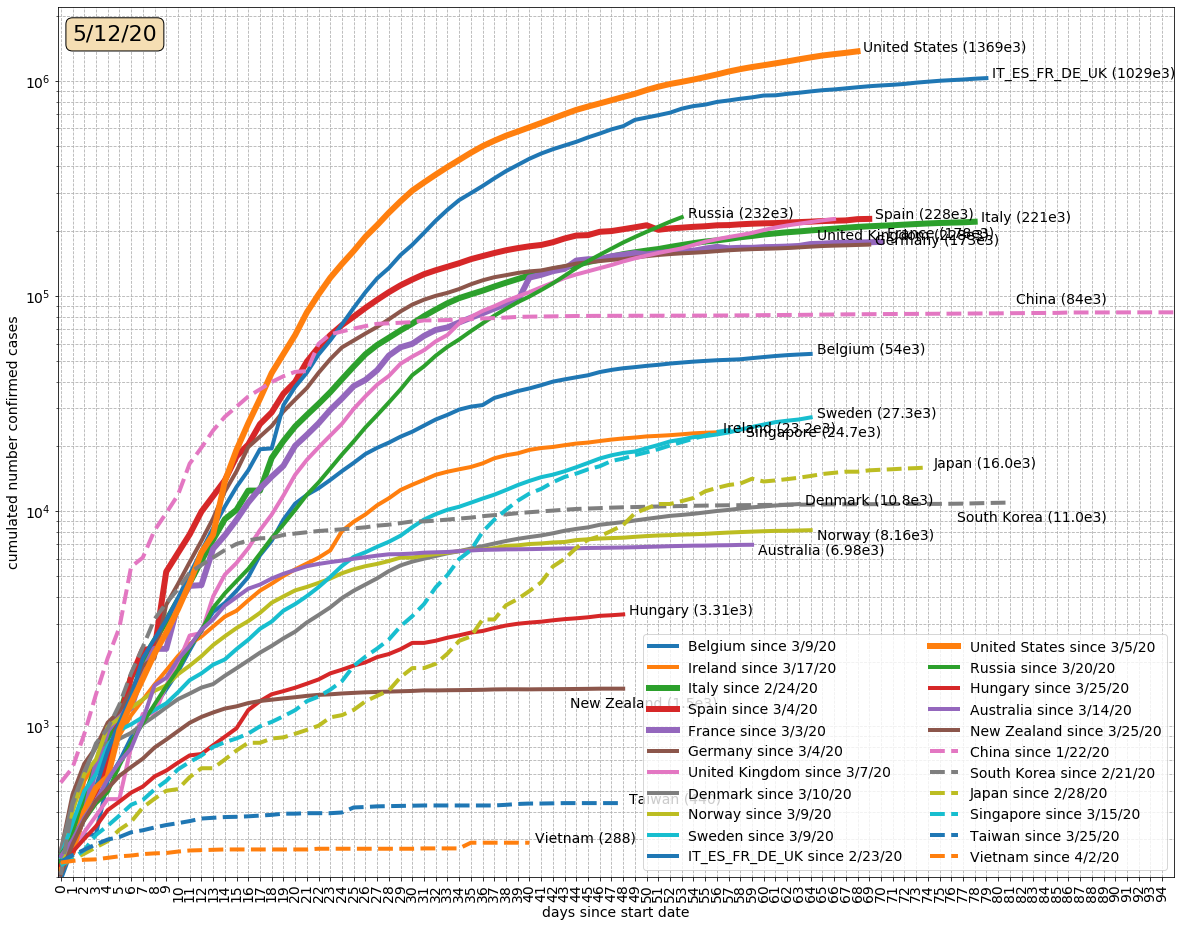

In [78]:
# LOG only, comparison of dynamics for countries
sel_date='2/24/20'
a=np.nonzero(covid2020_data_sel.columns.str.find(sel_date)==0)
cases_italy=covid2020_data_sel.loc['Italy'][np.arange(a[0],covid2020_data_sel.columns.size-1)]
days=np.arange(0,np.size(cases_italy))
ref_value=cases_italy[0]
#
fig=plt.figure(); ax2=fig.add_subplot(111); fig.set_size_inches(20,16)
ymaxval=1.1e6*np.ceil(np.max(np.max(covid2020_data_sel.iloc[:,:-1]))/1e6)
sample_cntrs=['Belgium','Ireland','Italy','Spain','France','Germany','United Kingdom',\
              'Denmark','Norway','Sweden',\
              'IT_ES_FR_DE_UK','United States',\
              'Russia','Hungary','Australia','New Zealand',
              'China','South Korea','Japan','Singapore','Taiwan','Vietnam'] 
####
dashed_cntrs=['China','South Korea','Japan','Singapore','Taiwan','Vietnam']; 
dotted_cntrs=[]; linewidth_incr_cntrs=['Italy','Spain','France','United States']
xlimvals=[0,days.size+16]; ylimvals=[2e2,ymaxval]; xtick_stepval=1; fontsizeval=14; linewidth_vals=[4,6]
log_flag=1; text_flag=1;
posit_modif_cntrs=[['China'],['Australia','Norway','Singapore'],\
                  ['United Kingdom'],['France'],['South Korea','New Zealand']]
posit_modif_vals=[[-10,1.1],[0,0.9],[-2,0.8],[0,1.05],[-5,0.82]]
####
fcn_plot_aligned(ax2,'cumul',covid2020_data_sel,[],sample_cntrs,\
                     ref_value,dashed_cntrs,dotted_cntrs,linewidth_incr_cntrs,\
                     xlimvals,ylimvals,xtick_stepval,fontsizeval,linewidth_vals,\
                     log_flag,text_flag,posit_modif_cntrs,posit_modif_vals)
#
last_date=covid2020_data_sel.columns[-2].replace('/','_')
plt.legend(loc='best',ncol=2) # ,bbox_to_anchor=(1.2, 1)
plt.xlabel("days since start date"); plt.ylabel("cumulated number confirmed cases"); 
ymax=1.25e6
plt.xticks(np.arange(0,xlimvals[1])); plt.xticks(rotation=90); plt.xlim(-0.25,xlimvals[1]); plt.ylim(ylimvals)
plt.grid(which='both',linestyle='--'); plt.rc('font',size=14)
# ax2.text(0.1,ymax*0.8,covid2020_data_sel.columns[-2],fontsize=22);
props=dict(boxstyle='round',facecolor='wheat',alpha=1)
ax2.text(xlimvals[0]+1,ylimvals[1]*0.7,covid2020_data_sel.columns[-2],fontsize=22,bbox=props);
plt.savefig("plots/cases_cntrs_aligned_log.png",bbox_inches='tight',pad_inches=0.05) # 

## Case # proportional to population

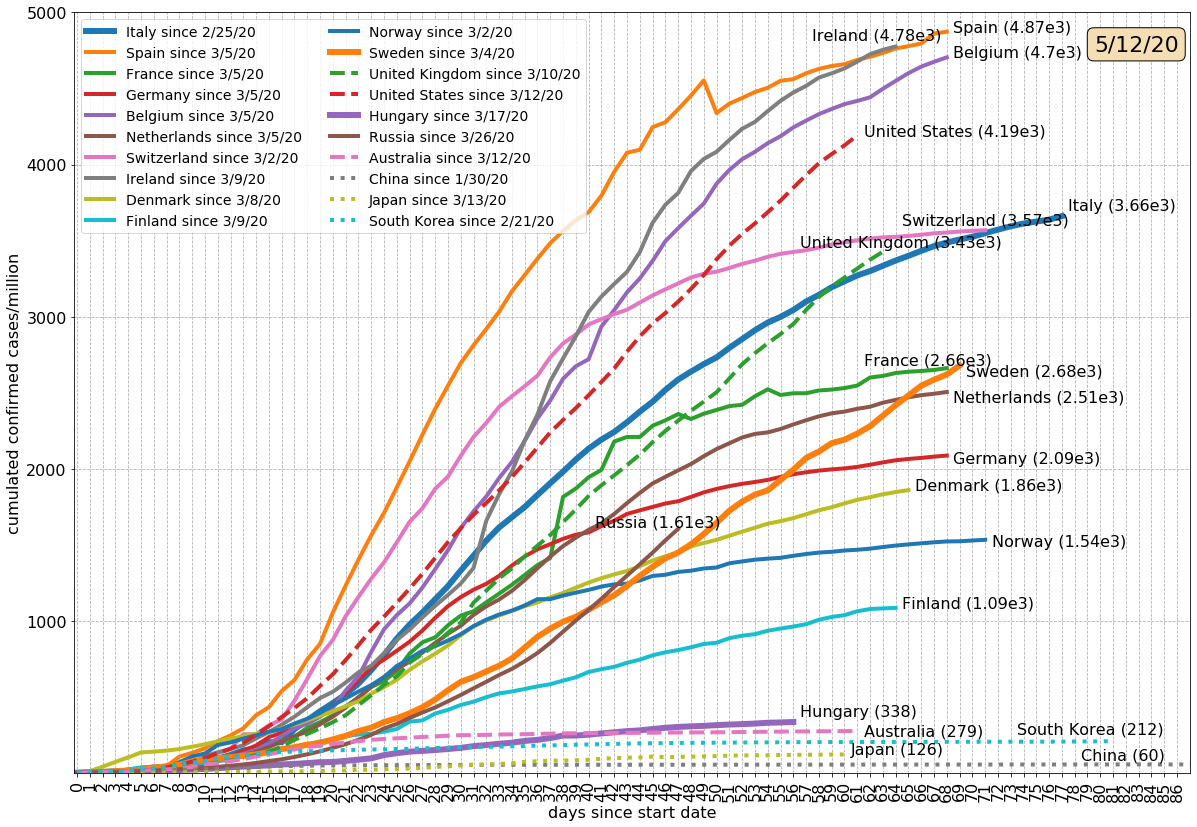

In [80]:
# Start date in italy
sel_date='2/25/20'
a=np.nonzero(covid2020_data_sel.columns.str.find(sel_date)==0)
cases_italy=covid2020_data_sel.loc['Italy'][np.arange(a[0],covid2020_data_sel.columns.size-1)]
pop_it_2018=worldpop2018.loc[worldpop2018['Country Name']=='Italy',"Value"].values[0]
ref_value=cases_it_per_pop=cases_italy[0]/pop_it_2018

sample_cntrs=['Italy','Spain','France','Germany',\
              'Belgium','Netherlands','Switzerland','Ireland',\
              'Denmark','Finland','Norway','Sweden',\
              'United Kingdom','United States',\
              'Hungary','Russia',\
              'Australia','China','Japan','South Korea']
xlimvals=[0,cases_italy.size+9]; ylimvals=[2,5e3]
dashed_cntrs=['United Kingdom','United States','Australia','New Zealand'];
linewidth_incr_cntrs=['Hungary','Sweden','Italy'];
dotted_cntrs=['China','Japan','South Korea']; 
log_flag=0; text_flag=1;
posit_modif_cntrs=[['Norway','Germany','Netherlands','Sweden'],['Hungary'],['Australia'],\
                   ['China'],['South Korea'],[''],['Italy'],\
                   ['Russia','Switzerland','Ireland','France','United Kingdom']]
posit_modif_vals=[[0,0.975],[0,1.12],[0,0.9],[-5,1.5],[-8,1.25],[-1,1.01],[0,1.01],[-7,1.01]]; # 
fig=plt.figure(); ax2=fig.add_subplot(111); fig.set_size_inches(20,14)
fcn_plot_aligned(ax2,'cumul',covid2020_data_sel,worldpop2018,sample_cntrs,\
                     ref_value,dashed_cntrs,dotted_cntrs,linewidth_incr_cntrs,\
                     xlimvals,ylimvals,xtick_stepval,fontsizeval,linewidth_vals,\
                     log_flag,text_flag,posit_modif_cntrs,posit_modif_vals)
#######
plt.legend(loc='best',ncol=2) # ,bbox_to_anchor=(0,0.16) 
plt.xlabel("days since start date"); plt.ylabel("cumulated confirmed cases/million"); 
plt.xticks(np.arange(0,xlimvals[1])); plt.xticks(rotation=90); 
plt.xlim(-0.25,xlimvals[1]); plt.ylim(ylimvals); 
plt.grid(which='both',linestyle='--'); plt.rc('font',size=16);
props=dict(boxstyle='round',facecolor='wheat',alpha=1)
ax2.text(xlimvals[1]-7.5,ylimvals[1]*0.95,covid2020_data_sel.columns[-2],fontsize=22,bbox=props);
####
plt.savefig("plots/cases_cntrs_aligned_perpop.png",bbox_inches='tight',pad_inches=0.05) # 

In [169]:
ylimvals

[100.0, 2400000.0]

## Plot of growth rate of cumul cases

In [1661]:
# % GROWTH RATE
# cutoff_cases=100
# sel_countrs=['Italy','Spain','Germany','France','Belgium','Ireland',\
#              'IT_ES_FR_DE_UK','Sweden',\
#              'Hungary','Russia',\
#              'United Kingdom','United States','Australia','New Zealand',\
#              'China','South Korea','India','Iran','Turkey','Saudi Arabia']
# cntr_truthval=covid2020_data_sel.index.str.contains('|'.join(sel_countrs))
# maxval=np.max(np.max(covid2020_data_sel.loc[cntr_truthval].iloc[:,:-1]))
# 
# # GROWTH on total number of cases or on population?
# growth_rate_flag='popul' # 'cumul','population'
# fig=plt.figure(); ax1=fig.add_subplot(111); fig.set_size_inches(12,8)
# ############
# dotted_cntrs=['China','South Korea','India','Turkey','Iran','Saudi Arabia','Spain','Italy']; 
# thickline_cntrs=['United Kingdom','IT_ES_FR_DE_UK','United States','Sweden']
# dashed_cntrs=['Australia','New Zealand']
# markervals=['','o']; linewidth_vals=[4,6]; growth_rate_flag='popul'
# ###
# loglog_flag=[1,1]; n_aver=3
# xlim_vals=[1e1,5e3]; ylim_vals=[2,2.25e2]; str_dtype="cases" # 1e-1,2.25e2
# fcn_plot_growth_rate(covid2020_data_sel,worldpop2018,sel_countrs,cutoff_cases,growth_rate_flag,n_aver,\
#                         dotted_cntrs,thickline_cntrs,dashed_cntrs,markervals,linewidth_vals,\
#                         loglog_flag,xlim_vals,ylim_vals,str_dtype)
# plt.grid(which='both',linestyle='--'); plt.legend(loc='best',ncol=2) # ,bbox_to_anchor=(0,0.09)
# plt.rc('font',size=14); props=dict(boxstyle='round',facecolor='wheat',alpha=1)
# if loglog_flag[1]==1:
#     ax1.text(xlim_vals[1]/5,ylim_vals[0]*2,covid2020_data_sel.columns[-2],fontsize=22,bbox=props);
# else:
#     ax1.text(xlim_vals[1]/5,ylim_vals[0]*2,covid2020_data_sel.columns[-2],fontsize=22,bbox=props);
# ######
# ylog_flag_str='_xlog'; 
# if loglog_flag[1]: ylog_flag_str='_loglog'
# 
# save_flag=1
# if save_flag:
#     if 'popul' in growth_rate_flag:
#         filename_rate="plots/growth_rate_cases_popul_cutoff"+str(cutoff_cases)+ylog_flag_str+".png"
#         plt.savefig(filename_rate,bbox_inches='tight',pad_inches=0.05)
#     elif 'cumul' in growth_rate_flag:
#         filename_deathrate="plots/growth_rate_cases_cumul_cutoff"+str(cutoff_cases)+".png"
#         plt.savefig(filename_rate,bbox_inches='tight',pad_inches=0.05)

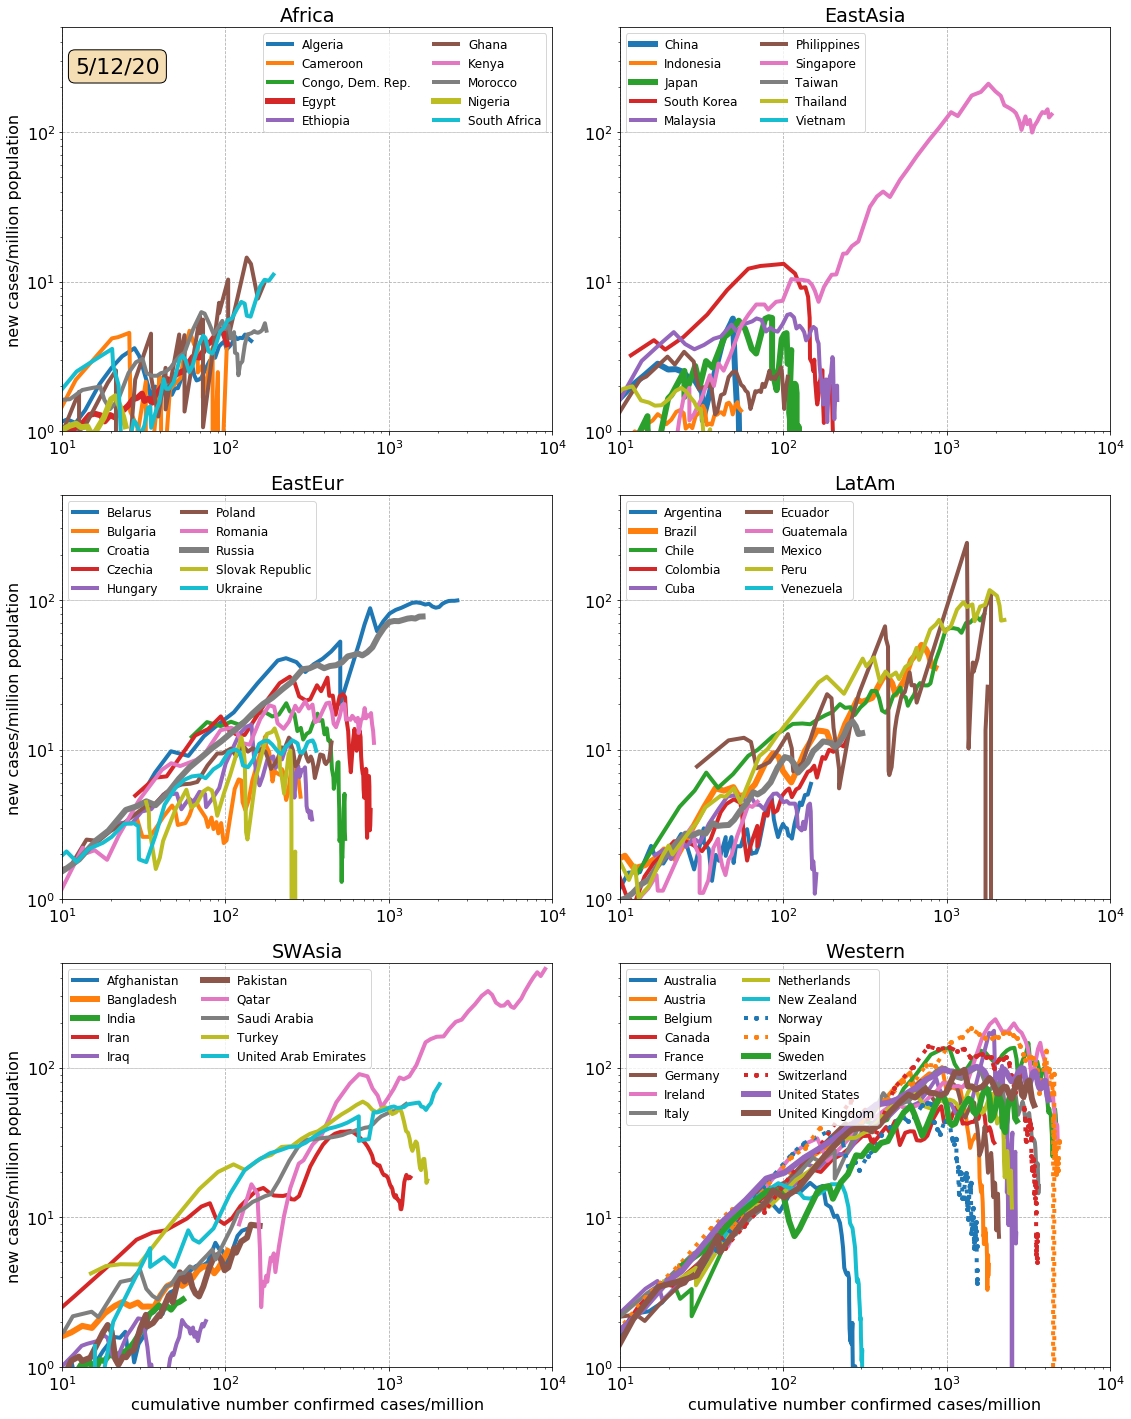

In [85]:
### several subplots

xlim_vals=[10,1e4]; ylim_vals=[1,5e2]; linewidth_vals=[3,5]; 
cutoff_cases=100; growth_rate_flag='popul'; n_aver=3; markervals=['','o']; linewidth_vals=[4,6]
#####
# LOGLOG?
loglog_flag=[1,1]
all_cntr_categs=np.unique(covid2020_data_sel.Continent)
props=dict(boxstyle='round',facecolor='wheat',alpha=1)
fig=plt.figure(); fig.set_size_inches(16,20); 
for i in range(len(all_cntr_categs)):
    ax1=fig.add_subplot(3,2,i+1); 
    sel_cntrs=list(covid2020_data_sel.index[covid2020_data_sel.Continent.str.contains(all_cntr_categs[i])])
    ncolval=2; fontval=12; str_dtype='cases'
    sel_cntrs=[sel_cntrs[i] for i in range(len(sel_cntrs)) if not sel_cntrs[i] in \
               ['IT_ES_FR_DE_UK','Denmark','Finland']]
    dotted_cntrs=[];thickline_cntrs=[];dashed_cntrs=[];  # 'Canada',
    if len(sel_cntrs)>10: 
        dotted_cntrs=sel_cntrs[10:]; fontval=12
        # if loglog_flag[1]: ncolval=3;
    thickline_cntrs=['China','Japan','Nigeria','Egypt','Brazil','Mexico','India','Pakistan',\
        'Bangladesh','Russia','United States','United Kingdom','Sweden']
    dotted_cntrs=[dotted_cntrs[i] for i in range(len(dotted_cntrs)) if not dotted_cntrs[i] \
     in ['United Kingdom','United States','Sweden']]
    fcn_plot_growth_rate(covid2020_data_sel,worldpop2018,sel_cntrs,cutoff_cases,growth_rate_flag,n_aver,\
                        dotted_cntrs,thickline_cntrs,dashed_cntrs,markervals,linewidth_vals,\
                        loglog_flag,xlim_vals,ylim_vals,str_dtype)
    plt.grid(which='major',linestyle='--'); plt.title(all_cntr_categs[i]); 
    if i>0: loc_flag='upper left';
    else: loc_flag='best';
    plt.legend(loc=loc_flag,ncol=ncolval,prop={"size":fontval}) # ,bbox_to_anchor=(0,0.09)
    if i<4: plt.xlabel('')
    if np.remainder(i,2)==1: plt.ylabel('')
    if i==0: ax1.text(xlim_vals[0]+2,ylim_vals[1]*0.5,covid2020_data_sel.columns[-2],fontsize=22,bbox=props);
fig.tight_layout()
######
# SAVE
save_flag=1
filename='multiplot_growth_rate_cases_popul_cutoff100_'; pdf_png='.png' # '.png' .pdf
if save_flag:
    if loglog_flag[1]:
        plt.savefig('plots/'+filename+'loglog'+pdf_png,bbox_inches='tight',pad_inches=0.05)
    else:
        plt.savefig('plots/'+filename+'xlog'+pdf_png,bbox_inches='tight',pad_inches=0.05)

In [360]:
# growth as a fcn of time

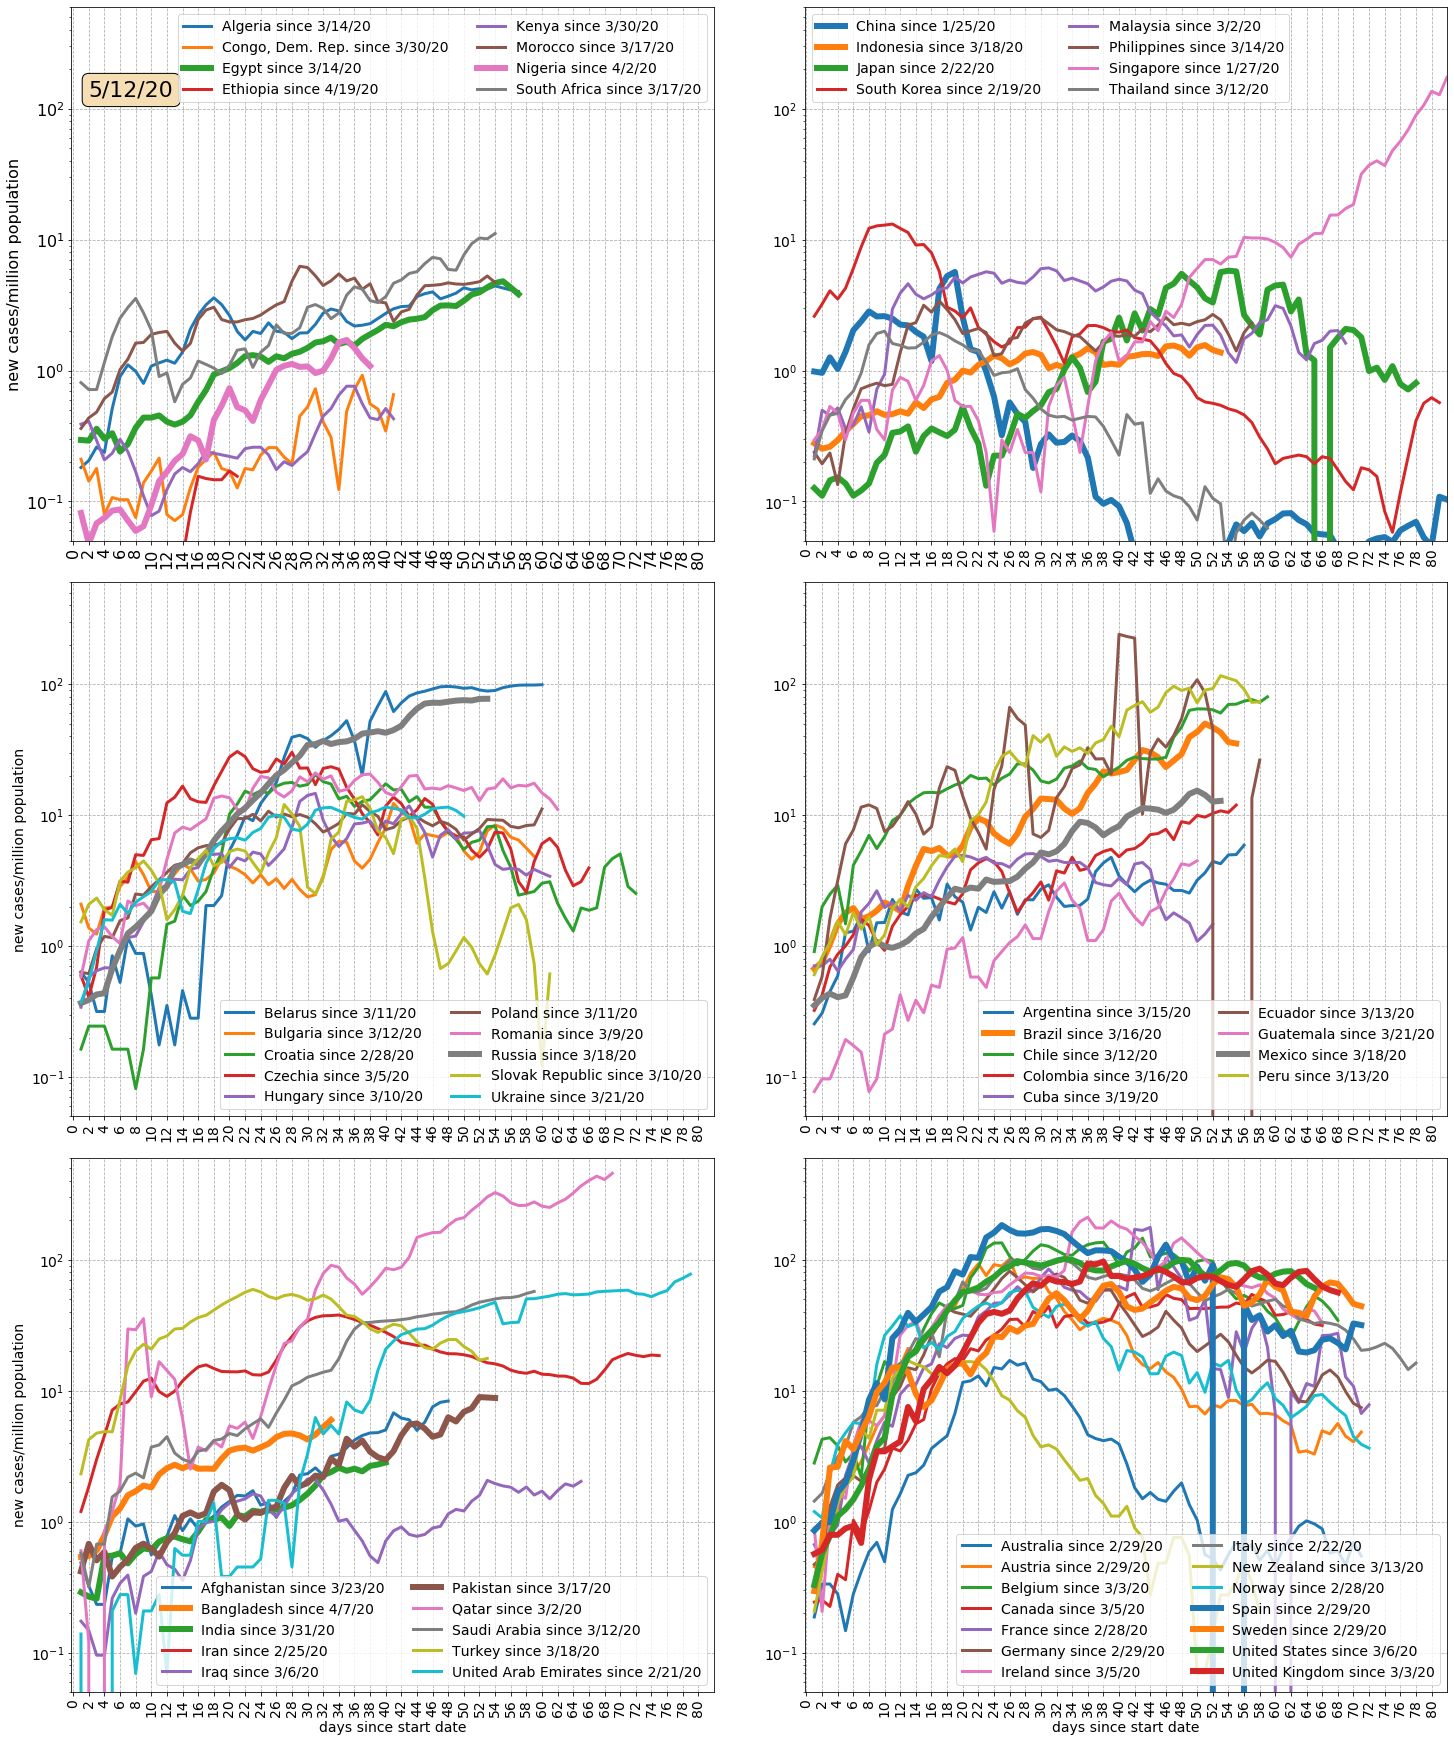

In [86]:
all_cntr_categs=np.unique(covid2020_data_sel.Continent)

ref_value=1
xlimvals=[-0.25,cases_italy.size+4]; ylimvals=[0.5e-1,6e2]; xlimval=xlimvals[1];
xtick_stepval=1; fontsizeval=15; linewidth_vals=[3,6]; log_flag=1; xtick_stepval=2
fig=plt.figure(); fig.set_size_inches(20,24); fontval=12; 
for i in range(len(all_cntr_categs)):
    ax=fig.add_subplot(3,2,i+1); 
    sel_cntrs=list(covid2020_data_sel.index[covid2020_data_sel.Continent.str.contains(all_cntr_categs[i])])
    ncolval=2; fontval=12; # sel_cntrs=sel_cntrs[7:]
    sel_cntrs=[sel_cntrs[j] for j in range(len(sel_cntrs)) if not sel_cntrs[j] in \
               ['Vietnam','Taiwan',\
                'Venezuela',\
                'Cameroon','Ghana',\
                'Netherlands','Switzerland','IT_ES_FR_DE_UK','Denmark','Finland']]
    # 'Slovak Republic',\ 
    # 'Cuba','Argentina','Guatemala',\
    #'Kenya','Congo, Dem. Rep.','Nigeria','Ethiopia',
    dashed_cntrs=[]; dotted_cntrs=[];linewidth_incr_cntrs=[]
    if len(sel_cntrs)>6:
        linewidth_incr_cntrs=['Egypt','Nigeria','Spain','United States','Sweden','United Kingdom',\
                              'Russia','China','Japan','Indonesia','India','Pakistan','Bangladesh',\
                              'Brazil','Mexico']; 
        if loglog_flag[1]: ncolval=2;
    # if len(sel_cntrs)>12: ncolval=3
    fcn_plot_aligned(ax,'diff',covid2020_data_sel,worldpop2018,sel_cntrs,\
                     ref_value,dashed_cntrs,dotted_cntrs,linewidth_incr_cntrs,\
                     xlimvals,ylimvals,xtick_stepval,fontsizeval,linewidth_vals,\
                     log_flag,text_flag,posit_modif_cntrs,posit_modif_vals)
    plt.legend(loc='best',ncol=ncolval,fontsize=14); plt.rc('font',size=14)
    plt.grid(which='major',axis='y',linestyle='--'); plt.grid(which='both',axis='x',linestyle='--')
    if i>3:
        plt.xlabel("days since start date");
    if np.remainder(i,2)==0:
        plt.ylabel("new cases/million population")
    if i==0: ax.text(2,ylim_vals[1]*0.25,covid2020_data_sel.columns[-2],fontsize=22,bbox=props);
#####
fig.tight_layout(pad=0, w_pad=0, h_pad=1)
#
save_flag=1
filename='multiplot_diff_cases_popul_cutoff100_'; pdf_png='.pdf' # '.png' pdf
if save_flag:
    if loglog_flag[1]:
        plt.savefig('plots/'+filename+'loglog'+pdf_png,bbox_inches='tight',pad_inches=0.05)
    else:
        plt.savefig('plots/'+filename+'xlog'+pdf_png,bbox_inches='tight',pad_inches=0.05)

In [490]:
fontsizeval

15

# Load data on fatalities

In [87]:
# Deaths
url='https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
filename_covid_timeseries='time_series_covid19_deaths_global.csv'
urllib.request.urlretrieve(url,filename_covid_timeseries)
covid2020_deaths=pd.read_csv(filename_covid_timeseries)

# filter
# ['Italy','Spain',\ 'Australia','New Zealand']

western_cntrs=['Austria','Switzerland','Belgium','Netherlands','Italy','Spain','France','Germany',\
               'United Kingdom','Ireland',\
               'Canada','US',\
               'Norway','Denmark','Finland','Sweden',\
               'New Zealand','Australia'] 
eastern_eur_cntrs=['Czechia','Hungary','Poland','Russia','Ukraine','Romania','Croatia',\
                   'Belarus','Bulgaria','Slovakia']
east_asian_cntrs=['Korea','Japan','China','Singapore','Taiwan','Thailand','Vietnam',\
             'Indonesia','Thailand','Malaysia','Philippines']
south_west_asia=['Bangladesh','India','Pakistan','Afghanistan','Iran','Turkey',\
                 'Iraq','Saudi Arabia','Qatar','United Arab Emirates']
latin_am_cntrs=['Argentina','Brazil','Colombia','Mexico','Peru','Venezuela','Chile','Ecuador','Guatemala','Cuba']
afr_cntrs=['Nigeria','Ethiopia','Egypt','South Africa','Algeria','Kenya','Morocco','Congo','Ghana','Cameroon']
# 
countries=western_cntrs+eastern_eur_cntrs+east_asian_cntrs+south_west_asia+latin_am_cntrs+afr_cntrs
#####
covid2020_deaths_sel=covid2020_deaths[covid2020_deaths['Country/Region'].str.contains('|'.join(countries))]
covid2020_deaths_sel=covid2020_deaths_sel.groupby(['Country/Region']).sum()
remove_cols=covid2020_deaths_sel.columns.str.contains('|'.join(['Lat','Long']))
covid2020_deaths_sel=covid2020_deaths_sel.iloc[:,~remove_cols]
str_IT_ES_FR_DE_UK=['Italy','Spain','France','Germany','United Kingdom']
# sum of EU big 5
covid2020_deaths_sel.loc['IT_ES_FR_DE_UK']=\
np.sum(covid2020_deaths_sel.iloc[covid2020_deaths_sel.index.str.contains('|'.join(str_IT_ES_FR_DE_UK)),:])
if not('IT_ES_FR_DE_UK' in western_cntrs): 
    western_cntrs.append('IT_ES_FR_DE_UK')
# renamings
# remove Brazzaville Congo: 
covid2020_deaths_sel=covid2020_deaths_sel[~covid2020_deaths_sel.index.str.contains('Brazzaville')]
covid2020_deaths_sel.rename(index={'Taiwan*': 'Taiwan'},inplace=True)
covid2020_deaths_sel.rename(index={'US': 'United States'},inplace=True)
covid2020_deaths_sel.rename(index={'Slovakia': 'Slovak Republic'},inplace=True)
western_cntrs[western_cntrs.index('US')]='United States'
eastern_eur_cntrs[eastern_eur_cntrs.index('Slovakia')]='Slovak Republic'
covid2020_deaths_sel.rename(index={'Korea, South': 'South Korea'},inplace=True);
east_asian_cntrs[east_asian_cntrs.index('Korea')]='South Korea'
covid2020_deaths_sel.rename(index={'Congo (Kinshasa)': 'Congo, Dem. Rep.'},inplace=True);
afr_cntrs[afr_cntrs.index('Congo')]='Congo, Dem. Rep.'


### Plot of # of cumulative (total) deaths, aligned to start from same level

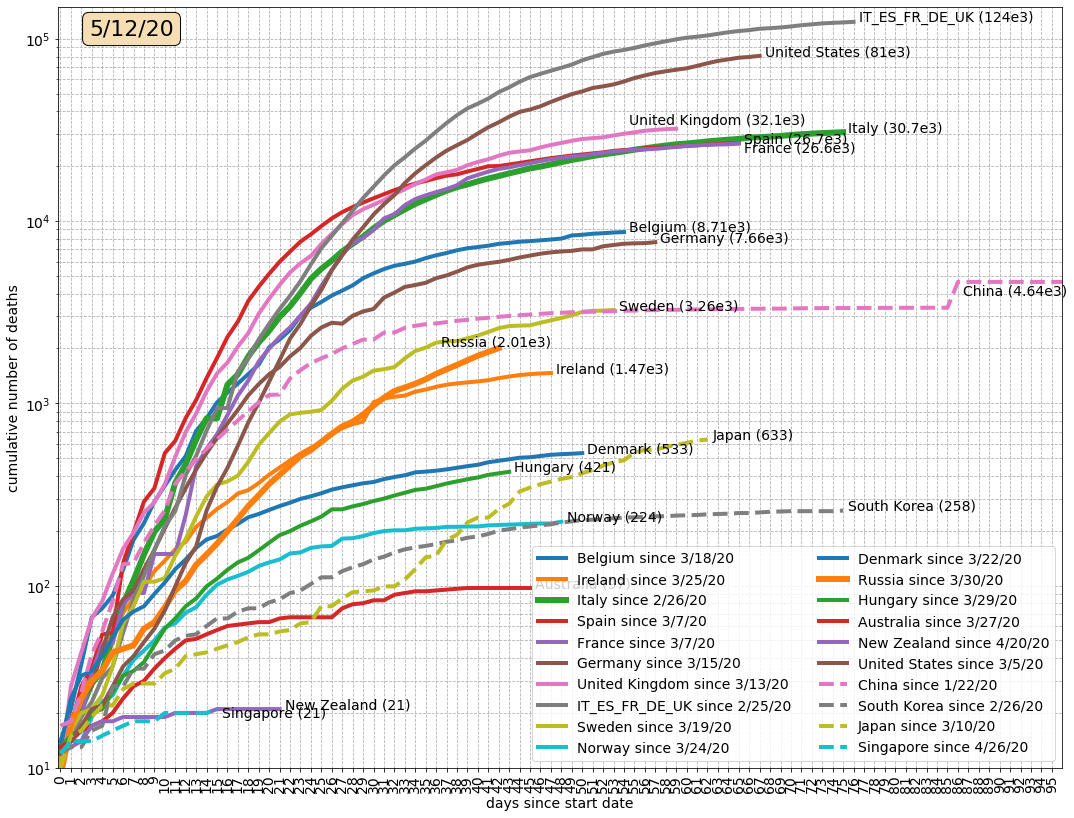

In [88]:
# total deaths
# LOG only, comparison of dynamics for countries
sel_date='2/26/20'
a=np.nonzero(covid2020_deaths_sel.columns.str.find(sel_date)==0)
cases_italy=covid2020_deaths_sel.loc['Italy'][np.arange(a[0],covid2020_deaths_sel.columns.size-1)]
days=np.arange(0,np.size(cases_italy))
ref_value=cases_italy[0]

fig=plt.figure(); ax2=fig.add_subplot(111); fig.set_size_inches(18,14)
sample_cntrs=['Belgium','Ireland','Italy','Spain','France','Germany','United Kingdom',\
              'IT_ES_FR_DE_UK',\
              'Sweden','Norway','Denmark',\
              'Russia','Hungary',\
              'Australia','New Zealand','United States',\
              'China','South Korea','Japan','Singapore']
dashed_cntrs=['China','South Korea','Japan','Singapore']; dotted_cntrs=[];linewidth_incr_cntrs=['Italy','Russia']
xlimvals=[-0.25,days.size+20]; ylimvals=[1e1,1.5e5]; xtick_stepval=1; fontsizeval=14;linewidth_vals=[4,6]
log_flag=1; text_flag=1; 
posit_modif_cntrs=[['China'],['Singapore','France'],['United Kingdom'],['Russia']]; 
posit_modif_vals=[[-6,0.85],[0,0.9],[-5,1.05],[-6,1.02]]
fcn_plot_aligned(ax2,'cumul',covid2020_deaths_sel,[],sample_cntrs,\
                     ref_value,dashed_cntrs,dotted_cntrs,linewidth_incr_cntrs,\
                     xlimvals,ylimvals,xtick_stepval,fontsizeval,linewidth_vals,\
                     log_flag,text_flag,posit_modif_cntrs,posit_modif_vals)
plt.legend(loc='best',ncol=2) # ,bbox_to_anchor=(1.2, 1)
plt.xlabel("days since start date"); plt.ylabel("cumulative number of deaths"); 
plt.xticks(np.arange(0,xlimvals[1])); plt.xticks(rotation=90)
plt.xlim(-0.25,xlimvals[1]); plt.ylim(ylimvals)
plt.grid(which='both',linestyle='--'); props=dict(boxstyle='round',facecolor='wheat',alpha=1)
ax2.text(xlimvals[0]+3,ylimvals[1]*0.7,covid2020_data_sel.columns[-2],fontsize=22,bbox=props);
plt.savefig("plots/deaths_cntrs_aligned_log.png",bbox_inches='tight',pad_inches=0.05)

## Proportional to population (fatalities)

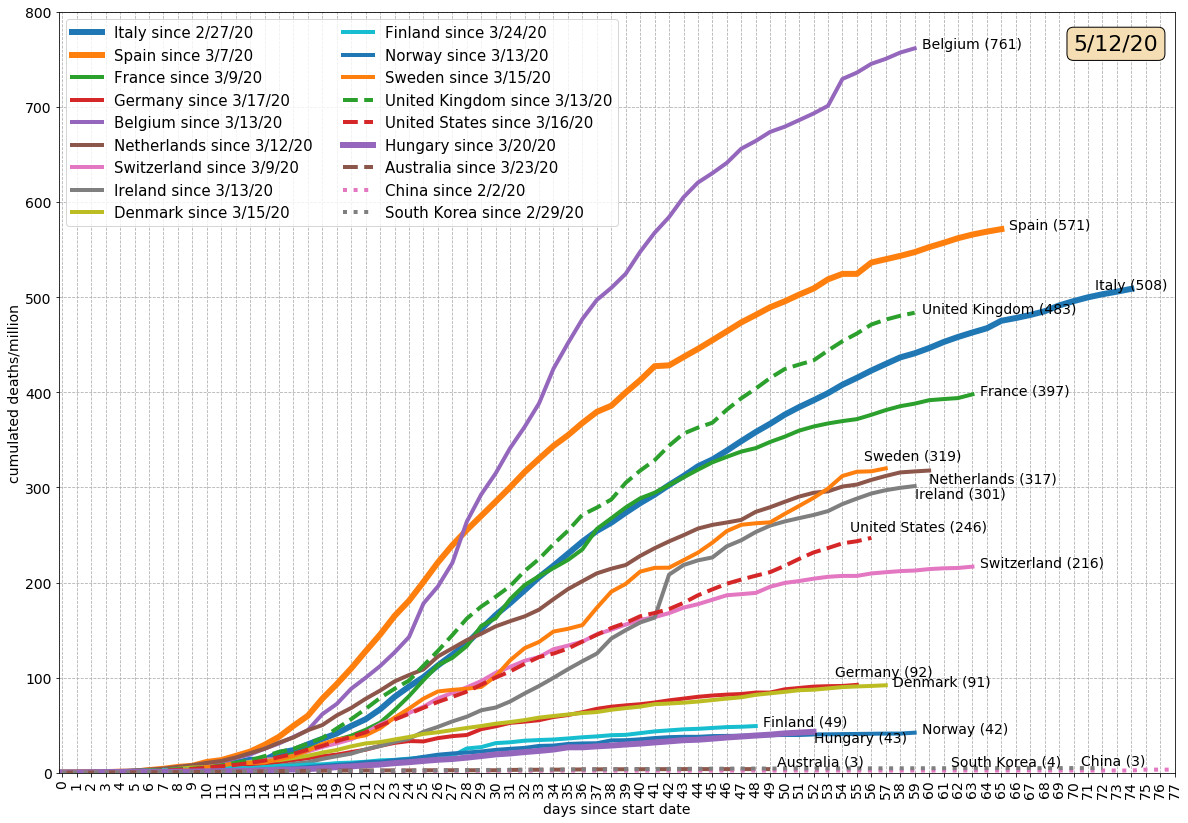

In [89]:
# proportional to population
worldpop2018=worldpop[worldpop['Year']==2018]
pop_it_2018=worldpop2018.loc[worldpop2018['Country Name']=='Italy',"Value"].values[0]

# start date in italy
sel_date='2/27/20'; a=np.nonzero(covid2020_deaths_sel.columns.str.find(sel_date)==0)
cases_italy=covid2020_deaths_sel.loc['Italy'][np.arange(a[0],covid2020_deaths_sel.columns.size-1)]
xlimvals=[-0.25,cases_italy.size]; ylimvals=[0,8e2]; xlimval=xlimvals[1];
xtick_stepval=1; fontsizeval=15; linewidth_vals=[4,6]
ref_value=cases_italy[0]/pop_it_2018; log_flag=0; text_flag=1

sample_cntrs=['Italy','Spain','France','Germany',\
              'Belgium','Netherlands','Switzerland','Ireland',\
              'Denmark','Finland','Norway','Sweden',\
              'United Kingdom','United States',\
              'Hungary',\
              'Australia','China','South Korea']
dashed_cntrs=['United Kingdom','United States','Australia','New Zealand']; 
dotted_cntrs=['China','South Korea'];
linewidth_incr_cntrs=['Italy','Spain','Hungary'] 
posit_modif_cntrs=[['Sweden','United States'],['Australia','New Zealand'],['Germany'],\
                   ['Ireland','Netherlands'],['China'],['South Korea'], ['Hungary']]
posit_modif_vals=[[-2,1.03],[0,2],[-2,1.1],[-0.5,0.96],[-1,2.5],[-10,1.5],[-0.5,0.75]]
fig=plt.figure(); ax=fig.add_subplot(111); fig.set_size_inches(20,14)
fcn_plot_aligned(ax,'cumul',covid2020_deaths_sel,worldpop2018,sample_cntrs,\
                     ref_value,dashed_cntrs,dotted_cntrs,linewidth_incr_cntrs,\
                     xlimvals,ylimvals,xtick_stepval,fontsizeval,linewidth_vals,\
                     log_flag,text_flag,posit_modif_cntrs,posit_modif_vals)
##
plt.legend(loc='best',ncol=2) # lower left ,bbox_to_anchor=(0,0.05)
plt.xlabel("days since start date"); plt.ylabel("cumulated deaths/million"); 
plt.xticks(np.arange(0,xlimvals[1]+3)); # plt.xticks(rotation=90); 
plt.xlim(-0.25,xlimvals[1]+2); plt.grid(which='both',linestyle='--'); plt.rc('font',size=14) # plt.ylim(ylimvals); 
props=dict(boxstyle='round',facecolor='wheat',alpha=1)
ax.text(xlimvals[1]-5,ylimvals[1]*0.95,covid2020_data_sel.columns[-2],fontsize=22,bbox=props);

plt.savefig("plots/deaths_cntrs_aligned_perpop.png",bbox_inches='tight',pad_inches=0.05) # 

## Growth rate of deaths

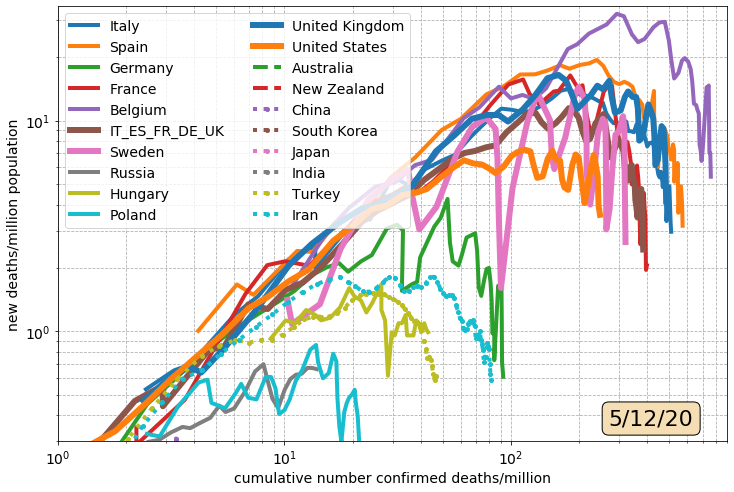

In [90]:
############
# % GROWTH RATE
cutoff_cases=50 # 'Switzerland','Ireland'
sel_countrs=['Italy','Spain','Germany','France',\
             'Belgium',\
             'IT_ES_FR_DE_UK',\
             'Sweden',\
             'Russia','Hungary','Poland',\
             'United Kingdom','United States',\
             'Australia','New Zealand',\
             'China','South Korea','Japan','India','Turkey','Iran']
cntr_truthval=covid2020_deaths_sel.index.str.contains('|'.join(sel_countrs))
maxval=np.max(np.max(covid2020_deaths_sel.loc[cntr_truthval].iloc[:,:-1]))
# GROWTH on total number of cases or on population?
growth_rate_flag='popul' # 'cumul','population'
fig=plt.figure(); ax1=fig.add_subplot(111); fig.set_size_inches(12,8)
############
dotted_cntrs=['China','South Korea','India','Japan','Turkey','Iran'];
thickline_cntrs=['IT_ES_FR_DE_UK','United States','Sweden','United Kingdom']
dashed_cntrs=['United Kingdom','Australia','New Zealand']
markervals=['','o']; linewidth_vals=[4,6]
growth_rate_flag='popul'; 
####
# LOGLOG?
loglog_flag=[1,1]
xlim_vals=[1,9e2]; ylim_vals=[3e-1,35] # [0,35] # [0.7,2.25e2]; 
str_dtype="deaths" # 1e-1,2.25e2
fcn_plot_growth_rate(covid2020_deaths_sel,worldpop2018,sel_countrs,cutoff_cases,growth_rate_flag,n_aver,\
                        dotted_cntrs,thickline_cntrs,dashed_cntrs,markervals,linewidth_vals,\
                        loglog_flag,xlim_vals,ylim_vals,str_dtype)
ylog_flag_str='_xlog'
if loglog_flag[1]: ylog_flag_str='_loglog'
plt.grid(which='both',linestyle='--'); plt.legend(loc='best',ncol=2) # ,bbox_to_anchor=(0,0.09)
props=dict(boxstyle='round',facecolor='wheat',alpha=1)
ax1.text(xlim_vals[1]*0.3,ylim_vals[0]*1.2,covid2020_data_sel.columns[-2],fontsize=22,bbox=props);
plt.rc('font',size=14)

if loglog_flag[1]: ylog_flag_str='_loglog'
save_flag=1
if save_flag:
    if 'popul' in growth_rate_flag:
        filename_deathrate="plots/growth_rate_deaths_popul_cutoff"+str(cutoff_cases)+ylog_flag_str+".png"
        plt.savefig(filename_deathrate,bbox_inches='tight',pad_inches=0.05)
    elif 'cumul' in growth_rate_flag:
        filename_deathrate="plots/growth_rate_deaths_cumul_cutoff"+str(cutoff_cases)+".png"
        plt.savefig(filename_deathrate,bbox_inches='tight',pad_inches=0.05)

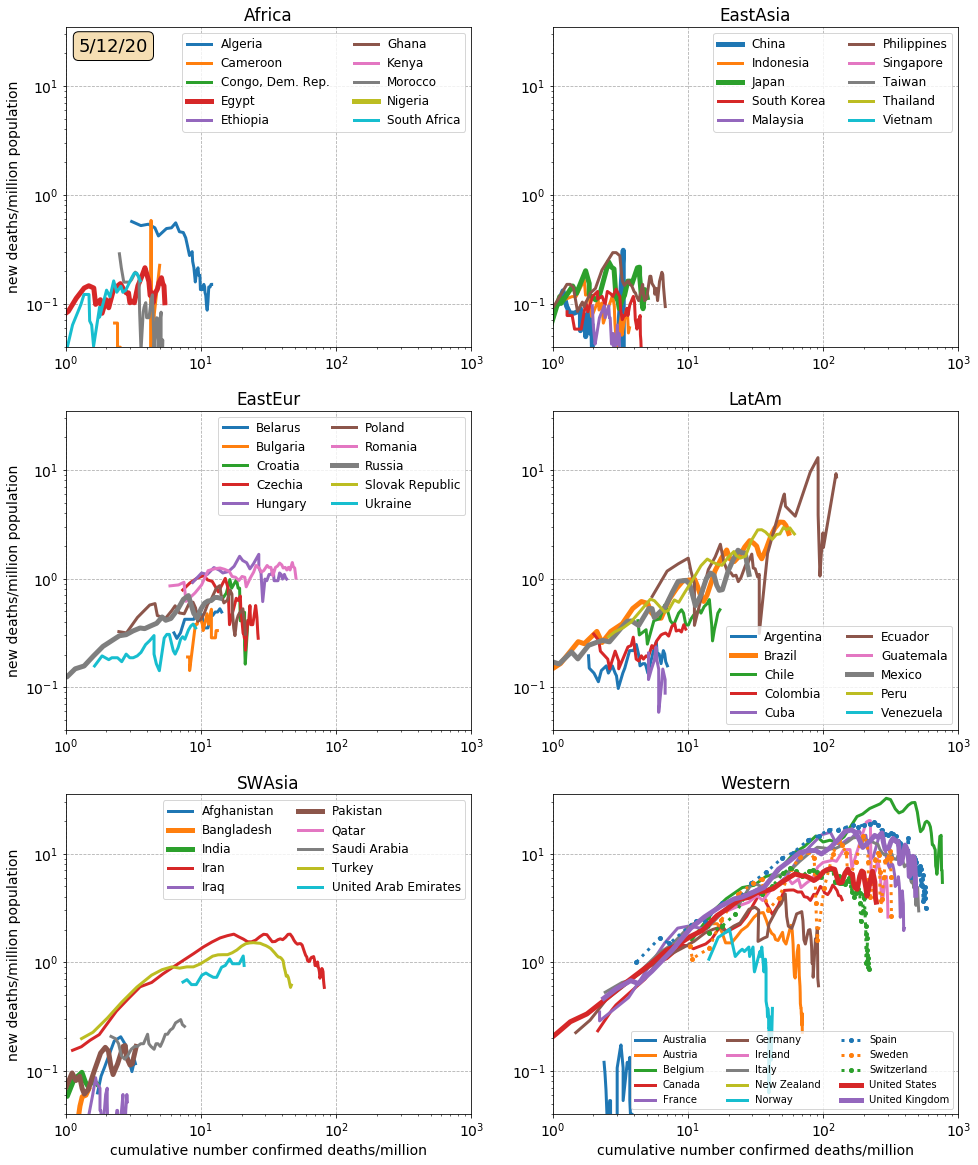

In [92]:
### several subplots
dotted_cntrs=[];thickline_cntrs=[];dashed_cntrs=[]; 
xlim_vals=[1e0,1e3]; ylim_vals=[4e-2,3.5e1]; 
linewidth_vals=[3,5]; cutoff_cases=50
############
# Y axis log?
loglog_flag=[1,1]
############
props=dict(boxstyle='round',facecolor='wheat',alpha=1)
all_cntr_categs=np.unique(covid2020_data_sel.Continent)
fig=plt.figure(); fig.set_size_inches(16,20)
for i in range(len(all_cntr_categs)):
    ax1=fig.add_subplot(3,2,i+1); 
    sel_cntrs=list(covid2020_data_sel.index[covid2020_data_sel.Continent.str.contains(all_cntr_categs[i])])
    ncolval=2; fontval=12;
    sel_cntrs=[sel_cntrs[i] for i in range(len(sel_cntrs)) if not sel_cntrs[i] in \
               ['Netherlands','IT_ES_FR_DE_UK','Denmark','Finland']] # ,'New Zealand'
    if len(sel_cntrs)>10:
        dotted_cntrs=sel_cntrs[10:]; fontval=10
        if loglog_flag[1]: ncolval=3;
    thickline_cntrs=['China','Japan','Nigeria','Egypt','Brazil','Mexico','India','Pakistan',\
        'Bangladesh','Russia','United States','United Kingdom','Sweden']
    dotted_cntrs=[dotted_cntrs[i] for i in range(len(dotted_cntrs)) if not dotted_cntrs[i] \
     in ['United Kingdom','United States']] # ,'Sweden'
    fcn_plot_growth_rate(covid2020_deaths_sel,worldpop2018,sel_cntrs,cutoff_cases,growth_rate_flag,n_aver,\
                        dotted_cntrs,thickline_cntrs,dashed_cntrs,markervals,linewidth_vals,\
                        loglog_flag,xlim_vals,ylim_vals,str_dtype)
    plt.grid(which='major',linestyle='--'); plt.title(all_cntr_categs[i]); 
    plt.legend(loc='best',ncol=ncolval,prop={"size":fontval}) # ,bbox_to_anchor=(0,0.09)
    if i<4: plt.xlabel('')
    if np.remainder(i,2)==1: plt.ylabel('')
    if i==0: ax1.text(xlim_vals[0]+1/4,ylim_vals[1]*0.6,covid2020_data_sel.columns[-2],fontsize=18,bbox=props);
# plt.rc('font',size=14); 
######
# SAVE
save_flag=1
filename='multiplot_growth_rate_deaths_popul_cutoff100_'; pdf_png='.pdf' # '.png' '.pdf'
if save_flag:
    if loglog_flag[1]:
        plt.savefig('plots/'+filename+'loglog'+pdf_png,bbox_inches='tight',pad_inches=0.05)
    else:
        plt.savefig('plots/'+filename+'xlog'+pdf_png,bbox_inches='tight',pad_inches=0.05)

# Our World in Data

In [69]:
url='https://covid.ourworldindata.org/data/owid-covid-data.csv'
owid_covid_data='owid-covid-data.csv'
urllib.request.urlretrieve(url,owid_covid_data)
covid2020_data_owid=pd.read_csv(owid_covid_data)

## Country lists

In [93]:
western_cntrs=['Italy', 'Spain', 'France','Germany','Austria', 'Switzerland', 'Belgium', 'Netherlands', \
               'Portugal','Greece', 'United Kingdom', 'Ireland', \
               'Norway', 'Denmark', 'Finland', 'Sweden', \
               'Canada', 'United States',\
                'Australia','New Zealand']
eastern_eur_cntrs=['Russia','Ukraine','Belarus','Czech Republic','Hungary','Slovakia','Poland','Romania',\
                   'Croatia','Serbia','Bulgaria','Lithuania']
east_asian_cntrs=['South Korea','Japan','China','Singapore','Taiwan','Vietnam',\
             'Indonesia','Thailand','Malaysia','Philippines']
south_west_asia=['Bangladesh','India','Pakistan','Afghanistan','Iran','Turkey',\
                 'Iraq','Saudi Arabia','Qatar','United Arab Emirates']
latin_am_cntrs=['Argentina','Brazil','Colombia','Mexico','Peru','Venezuela','Chile','Ecuador','Guatemala','Cuba']
afr_cntrs=['Algeria','Cameroon','Democratic Republic of Congo','Egypt','Ethiopia',\
           'Ghana', 'Kenya','Morocco', 'Nigeria', 'South Africa','Tunisia']

cntr_lists=[western_cntrs,eastern_eur_cntrs,east_asian_cntrs,south_west_asia,latin_am_cntrs,afr_cntrs]
region_flags=['west','east_eur','east_asia','sw_asia','latin_am','africa']

all_dates=np.unique(covid2020_data_owid['date'])

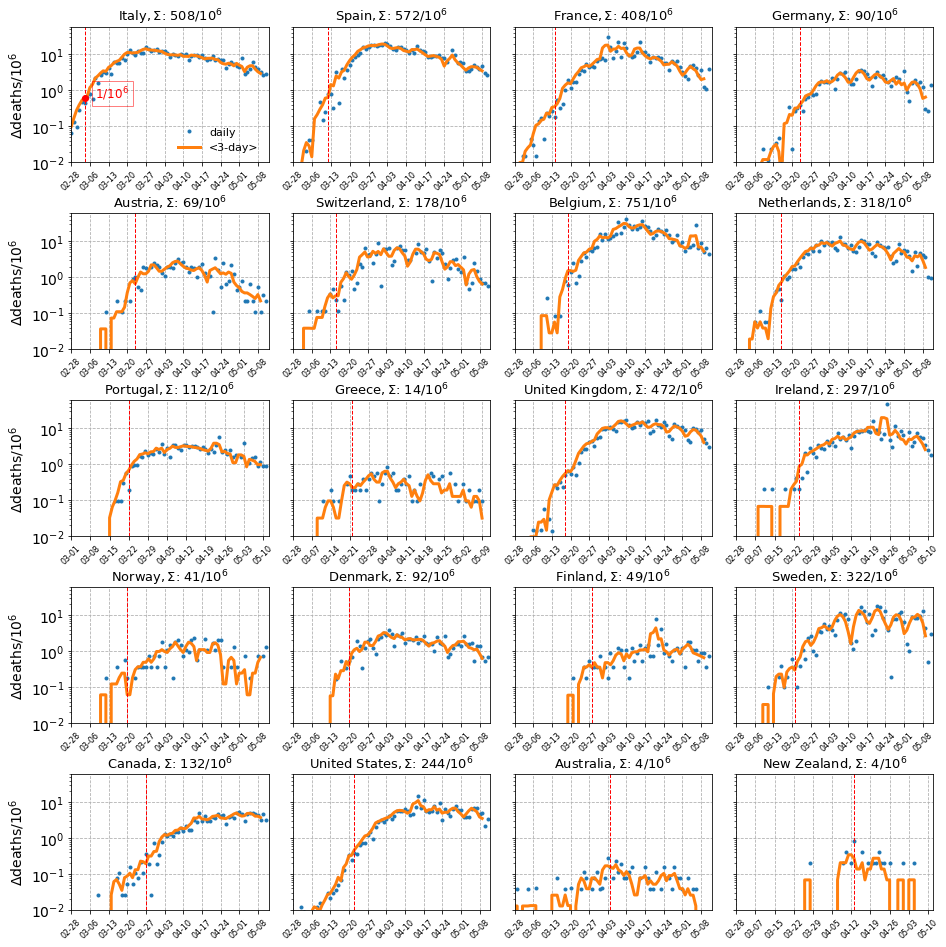

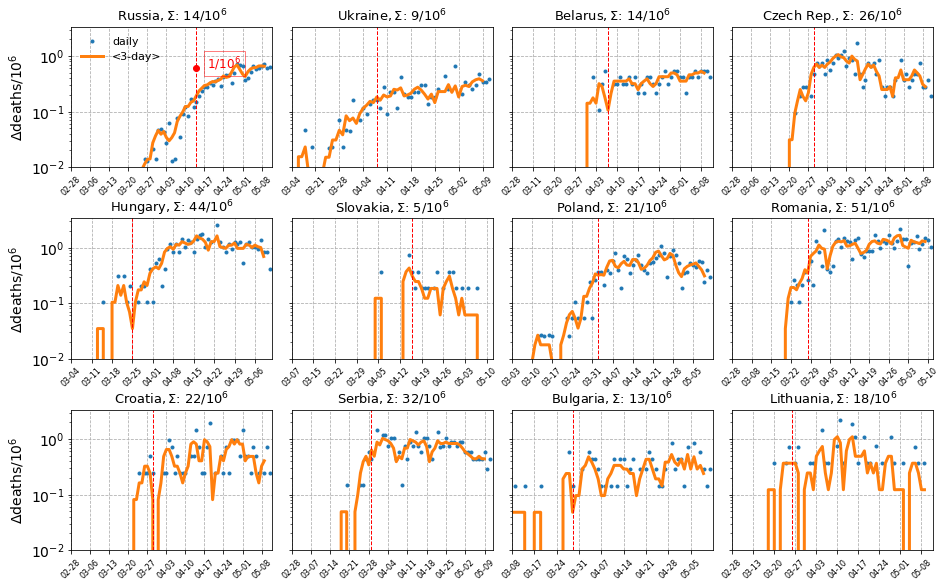

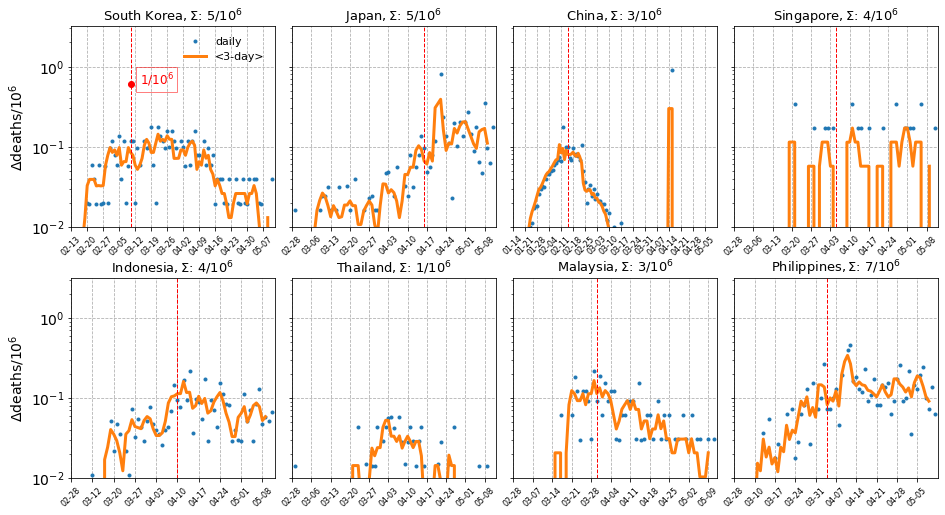

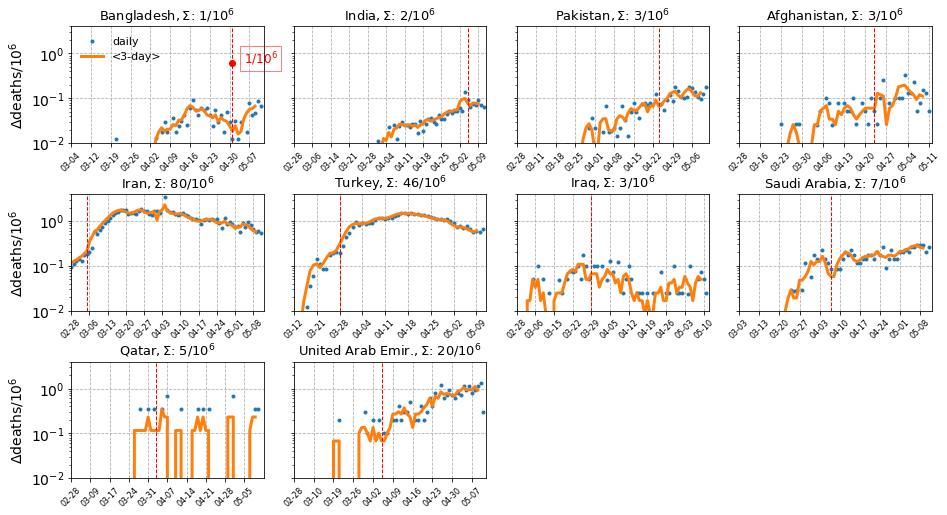

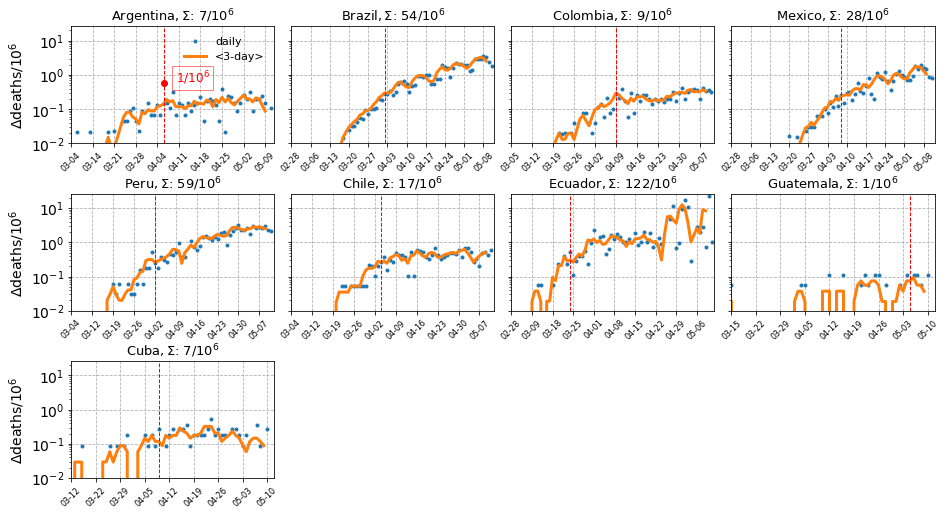

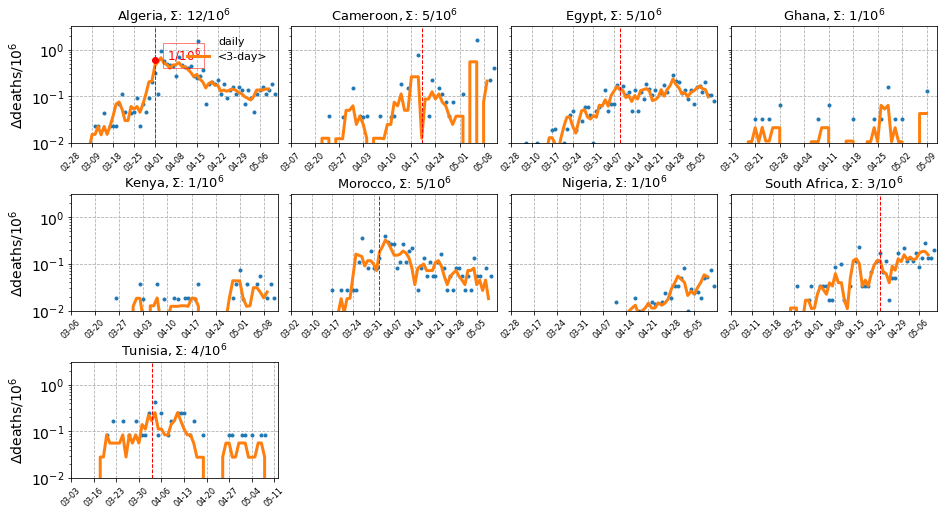

In [95]:
plt.rc('text',usetex=False); plt.rc('font', family='sans serif'); pdf_png='.pdf'; # plt.rc('text', usetex=True)
n_col=4; n_aver=3; 
#####
var_type='deaths'; plot_var_name='total_'+var_type+'_per_million'; diff_plot_var_name='new_'+var_type+'_per_million'
filename='plots/multiplot_daily_incr_sep_cntrs/multiplot_'+var_type+'_daily_incr_'
#####
if var_type=='cases': start_thresh=10; start_date='2020-02-21';fig_height=3;log_thresh=10**1.5;ylimvals=[0.1,100]; 
else: start_thresh=1; start_date='2020-02-28'; fig_height=2.5; log_thresh=10**0.5; ylimvals=[0.01,100]; 

# China and SKor started from earlier date
cn_shift=45;skor_shift=15; 
cn_start_date=all_dates[np.where(all_dates==start_date)[0][0]-cn_shift]; 
sk_start_date=all_dates[np.where(all_dates==start_date)[0][0]-skor_shift]
cn_diff_mean=covid2020_data_owid[(covid2020_data_owid['location']=='China')&(covid2020_data_owid['date']>\
                                  cn_start_date)].mean()[diff_plot_var_name]
skor_diff_mean=covid2020_data_owid[(covid2020_data_owid['location']=='South Korea')&(covid2020_data_owid['date']>\
                                  cn_start_date)].mean()[diff_plot_var_name]

#######
# loop through
for j in range(len(cntr_lists)): # :# range(len(cntr_lists)): # [3,4,5]: #
    cntr_list=cntr_lists[j] # western_cntrs
    fig=plt.figure(); fig.set_size_inches(13,np.ceil(fig_height*len(cntr_list)/n_col))
    cont_cntrs=covid2020_data_owid[covid2020_data_owid['location'].str.contains('$|'.join(cntr_list))]
    cont_cntrs=cont_cntrs[cont_cntrs['date']>start_date]
    diff_means=cont_cntrs.groupby('location').mean()[diff_plot_var_name]
    if 'China' in cntr_list:
        diff_means[diff_means.index.values=='China']=cn_diff_mean; 
        diff_means[diff_means.index.values=='South Korea']=skor_diff_mean; 
    means_sup_thresh=diff_means[diff_means>ylimvals[0]]
    subplot_n=np.sum(diff_means>ylimvals[0])
    diff_max=cont_cntrs.groupby('location')[diff_plot_var_name].max(); diff_max=diff_max[diff_max>ylimvals[0]]
    cont_max=np.max(diff_max); round_log=10**np.round(np.log10(cont_max))
    diff_smooth_max=np.max([np.max(running_mean(\
        cont_cntrs[cont_cntrs['location']==cntr][diff_plot_var_name].values,n_aver)) for cntr in cntr_list])
    ylimvals[1]=np.round(diff_smooth_max/round_log,1)*round_log
    # LOGARITHMIC Y
    if cont_max/np.min(diff_max)>log_thresh:
        if var_type=='cases': ymin_scale=1
        else: ymin_scale=0.5
        y_textbox=ylimvals[0]*3; ylimvals[1]=np.max([10**ymin_scale,ylimvals[1]*2])
    else: y_textbox=ylimvals[1]/2
    subpl_i=0;
    for i in range(len(cntr_list)):
        cntr_vals=covid2020_data_owid['location'].str.contains(cntr_list[i]+'$')
        dates=covid2020_data_owid[cntr_vals]['date']; 
        if np.sum(dates.str.contains(start_date)): start_date_ind=np.where(dates==start_date)[0][0]
        else: start_date_ind=np.min(np.where(dates>start_date))
        if cntr_list[i]=='China': start_date_ind=start_date_ind-cn_shift
        if cntr_list[i]=='South Korea': start_date_ind=start_date_ind-skor_shift
        date_vals=dates[start_date_ind:-1]
        date_vals=[w.replace('2020-', '') for w in date_vals.values]
        total_per_million=covid2020_data_owid[cntr_vals][plot_var_name]
        ####
        if np.nanmean(np.diff(total_per_million[start_date_ind:]))>ylimvals[0]:
            subpl_i=subpl_i+1; ax1=fig.add_subplot(np.ceil(subplot_n/n_col),n_col,subpl_i); 

            ax1.plot(date_vals,np.diff(total_per_million[start_date_ind:]),label='daily',\
                     linestyle='',linewidth=0.5,marker='.') 
            if cont_max/np.min(diff_max)>log_thresh: plt.yscale('log') 
            plt.grid(axis='x',which='both',linestyle='--'); plt.grid(axis='y',which='major',linestyle='--');
            # moving average
            aver_vals=running_mean(np.diff(total_per_million[start_date_ind:]),n_aver)
            ax1.plot(date_vals[:-(n_aver-1)],aver_vals,linewidth=3,label='<3-day>');
            # axis ticks
            plt.xticks(np.arange(0,len(date_vals),step=7),rotation=45,fontsize=8);
            if np.remainder(subpl_i,n_col)==1: ax1.set_ylabel('$\Delta$'+var_type+'$/10^6$')
            else: ax1.set_yticklabels('')
            plt.xlim([0,len(dates[start_date_ind:-1])]); plt.ylim(ylimvals) 
            # country
            title_str=cntr_list[i].replace('Democratic','Dem.').replace('Republic','Rep.').replace('of ','')
            title_str=title_str.replace('Emirates','Emir.')
            plt.title(title_str+'$, \Sigma$: '+\
                      str(int(np.round(total_per_million[-1:].values[0])))+'/$10^6$',fontsize=13)
            # when value exceeded 1/million
            if np.sum(total_per_million[start_date_ind:]>start_thresh):
                redline_xpos=np.min(np.where(total_per_million[start_date_ind:]>start_thresh))
                ax1.axvline(redline_xpos,linestyle='--',linewidth=1,color='red')
                if i==0: 
                    props = dict(boxstyle='square',facecolor='none',edgecolor='red',alpha=0.5)
                    plt.legend(fontsize=11,framealpha=0); text_lag=4
                    if redline_xpos>len(date_vals)-7: text_lag=-15
                    if y_textbox<np.nanmax(np.diff(total_per_million)): 
                        y_textbox=np.min([y_textbox*20,ylimvals[1]/2])
                    ax1.text(redline_xpos+text_lag,y_textbox,str(int(start_thresh))+'$/10^6$',color='red',\
                             bbox=props,fontsize=12); plt.plot(redline_xpos,y_textbox,'ro'); 
    plt.tight_layout(pad=0.1,w_pad=0.1,h_pad=0.1); # 
    plt.savefig(filename+region_flags[j]+pdf_png,pad_inches=0.05,bbox_inches='tight') 
####


In [44]:
plot_var_name

'total_cases_per_million'

## Cases-deaths/million plots

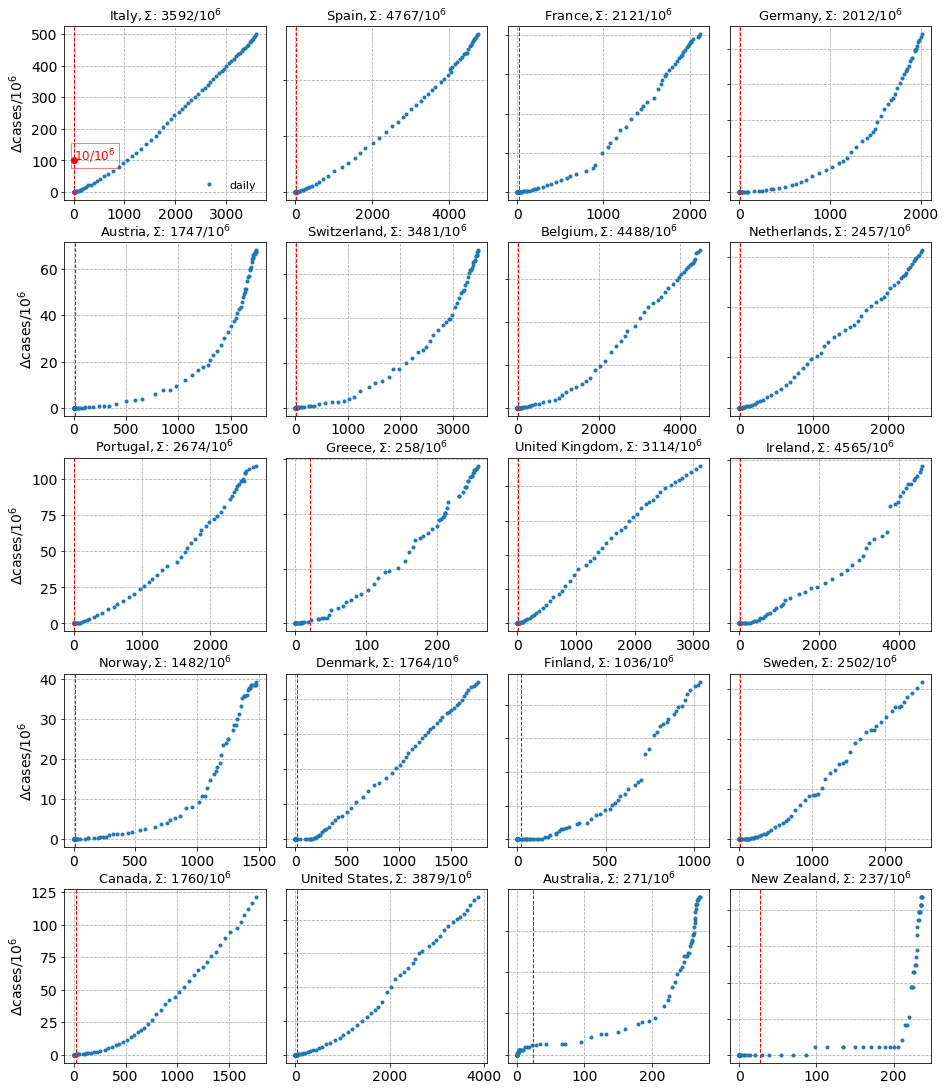

In [48]:


for j in [0]: # :# range(len(cntr_lists)): # [3,4,5]: #
    cntr_list=cntr_lists[j] # western_cntrs
    fig=plt.figure(); fig.set_size_inches(13,np.ceil(fig_height*len(cntr_list)/n_col))
    cont_cntrs=covid2020_data_owid[covid2020_data_owid['location'].str.contains('$|'.join(cntr_list))]
    cont_cntrs=cont_cntrs[cont_cntrs['date']>start_date]
    diff_means=cont_cntrs.groupby('location').mean()[diff_plot_var_name]
    if 'China' in cntr_list:
        diff_means[diff_means.index.values=='China']=cn_diff_mean; 
        diff_means[diff_means.index.values=='South Korea']=skor_diff_mean; 
    means_sup_thresh=diff_means[diff_means>ylimvals[0]]
    subplot_n=np.sum(diff_means>ylimvals[0])
    diff_max=cont_cntrs.groupby('location')[diff_plot_var_name].max(); diff_max=diff_max[diff_max>ylimvals[0]]
    cont_max=np.max(diff_max); round_log=10**np.round(np.log10(cont_max))
    diff_smooth_max=np.max([np.max(running_mean(\
        cont_cntrs[cont_cntrs['location']==cntr][diff_plot_var_name].values,n_aver)) for cntr in cntr_list])
    ylimvals[1]=np.round(diff_smooth_max/round_log,1)*round_log
    # LOGARITHMIC Y
    if cont_max/np.min(diff_max)>log_thresh:
        if var_type=='cases': ymin_scale=1
        else: ymin_scale=0.5
        y_textbox=ylimvals[0]*3; ylimvals[1]=np.max([10**ymin_scale,ylimvals[1]*2])
    else: y_textbox=ylimvals[1]/2
    subpl_i=0;
    for i in range(len(cntr_list)):
        cntr_vals=covid2020_data_owid['location'].str.contains(cntr_list[i]+'$')
        dates=covid2020_data_owid[cntr_vals]['date']; 
        if np.sum(dates.str.contains(start_date)): start_date_ind=np.where(dates==start_date)[0][0]
        else: start_date_ind=np.min(np.where(dates>start_date))
        if cntr_list[i]=='China': start_date_ind=start_date_ind-cn_shift
        if cntr_list[i]=='South Korea': start_date_ind=start_date_ind-skor_shift
        date_vals=dates[start_date_ind:-1]
        date_vals=[w.replace('2020-', '') for w in date_vals.values]
        total_cases_per_million=covid2020_data_owid[cntr_vals]['total_cases_per_million']
        total_deaths_per_million=covid2020_data_owid[cntr_vals]['total_deaths_per_million']
        ####
        if np.nanmean(np.diff(total_cases_per_million[start_date_ind:]))>ylimvals[0]:
            subpl_i=subpl_i+1; ax1=fig.add_subplot(np.ceil(subplot_n/n_col),n_col,subpl_i); 

            ax1.plot(total_cases_per_million[start_date_ind:],total_deaths_per_million[start_date_ind:],label='daily',\
                     linestyle='',linewidth=0.5,marker='.') 
            if cont_max/np.min(diff_max)>log_thresh: plt.yscale('log') 
            plt.grid(axis='x',which='both',linestyle='--'); plt.grid(axis='y',which='major',linestyle='--');
            # axis ticks
            # plt.xticks(np.arange(0,len(date_vals),step=7),rotation=45,fontsize=8);
            if np.remainder(subpl_i,n_col)==1: ax1.set_ylabel(var_type+'$/10^6$')
            else: ax1.set_yticklabels('')
            # plt.xlim([0,len(dates[start_date_ind:-1])]); plt.ylim(ylimvals) 
            # country
            title_str=cntr_list[i].replace('Democratic','Dem.').replace('Republic','Rep.').replace('of ','')
            title_str=title_str.replace('Emirates','Emir.')
            plt.title(title_str+'$, \Sigma$: '+\
                      str(int(np.round(total_cases_per_million[-1:].values[0])))+'/$10^6$',fontsize=13)
            # when value exceeded 1/million
            if np.sum(total_cases_per_million[start_date_ind:]>start_thresh):
                redline_xpos=np.min(np.where(total_cases_per_million[start_date_ind:]>start_thresh))
                ax1.axvline(redline_xpos,linestyle='--',linewidth=1,color='red')
                if i==0: 
                    props = dict(boxstyle='square',facecolor='none',edgecolor='red',alpha=0.5)
                    plt.legend(fontsize=11,framealpha=0); text_lag=4
                    if redline_xpos>len(date_vals)-7: text_lag=-15
                    if y_textbox<np.nanmax(np.diff(total_cases_per_million)): 
                        y_textbox=np.min([y_textbox*20,ylimvals[1]/2])
                    ax1.text(redline_xpos+text_lag,y_textbox,str(int(start_thresh))+'$/10^6$',color='red',\
                             bbox=props,fontsize=12); plt.plot(redline_xpos,y_textbox,'ro'); 
    plt.tight_layout(pad=0.1,w_pad=0.1,h_pad=0.1); # 